<a href="https://colab.research.google.com/github/0Pedrh0/Automatic_Speech_Processing/blob/main/Projet_3EN_TSI_2025_DNN_TIMIT_Hanni_Benarib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet 3EA : Reconnaissance de phonèmes avec DNN

Ce notebook va vous mettre à disposition une préparation des données et une modélisation très simple. Vous aurez à améliorer cette modélisation pour obtenir de meilleurs performances.

**NOM1** : Hani

**Prénom1** : Badreddine

**Email1** : badrhanib@gmail.com        

**NOM2** : Benarib

**Prénom2** : Ilyes

**Email2** : benarib.ilyes@gmail.com

##Initialisation de l'environnement de TP

Téléchargez les données, puis décompressez-les.
Vous devriez avoir :

`timit_11/`
- `train_11.npy`: données acoustiques<br>
- `train_label_11.npy`: étiquettes associées<br>

In [1]:
# OS setup
#!cat /etc/os-release
!apt-get install -qq tree

#!rm -rf reco-parole-dnn

# Liaison avec les données
!git clone https://gitlab.com/jeromefarinas/reco-parole-dnn.git
!cd reco-parole-dnn && git lfs pull

Selecting previously unselected package tree.
(Reading database ... 126675 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...
Cloning into 'reco-parole-dnn'...
remote: Enumerating objects: 7, done.
remote: Total 7 (delta 0), reused 0 (delta 0), pack-reused 7 (from 1)
Receiving objects: 100% (7/7), done.


In [2]:
!unzip reco-parole-dnn/timit_11.zip
!tree timit_11/

Archive:  reco-parole-dnn/timit_11.zip
   creating: timit_11/
  inflating: __MACOSX/._timit_11     
  inflating: timit_11/train_11.npy   
  inflating: __MACOSX/timit_11/._train_11.npy  
  inflating: timit_11/test_11.npy    
  inflating: __MACOSX/timit_11/._test_11.npy  
  inflating: timit_11/train_label_11.npy  
  inflating: __MACOSX/timit_11/._train_label_11.npy  
timit_11/
├── test_11.npy
├── train_11.npy
└── train_label_11.npy

0 directories, 3 files


In [19]:
import numpy as np

print('Loading data ...')

data_root='./timit_11/'
train = np.load(data_root + 'train_11.npy')
train_label = np.load(data_root + 'train_label_11.npy')

print('Taille des données : {}'.format(train.shape))

Loading data ...
Taille des données : (1229932, 429)


## Création de la base de données

In [20]:
import torch
from torch.utils.data import Dataset

class TIMITDataset(Dataset):
    def __init__(self, X, y=None):
        self.data = torch.from_numpy(X).float()
        if y is not None:
            y = y.astype(int)
            self.label = torch.LongTensor(y)
        else:
            self.label = None

    def __getitem__(self, idx):
        if self.label is not None:
            return self.data[idx], self.label[idx]
        else:
            return self.data[idx]

    def __len__(self):
        return len(self.data)


Diviser les données étiquetées en un ensemble d'entraînement et un ensemble de validation, vous pouvez modifier la variable `VAL_RATIO` pour changer le ratio des données de validation.

# la dimension d'arrivée (429) est issue de 11 fenêtres de 39 paramètres issus de MFCC (12 MFCC + E + Delta + Delta Delta)

In [21]:
VAL_RATIO = 0.15

percent = int(train.shape[0] * (1 - VAL_RATIO))
train_x, train_y, val_x, val_y = train[:percent], train_label[:percent], train[percent:], train_label[percent:]
print('Taille de l\'ensemble d\'apprentissage : {}'.format(train_x.shape))
print('Taille de l\'ensemble de validation: {}'.format(val_x.shape))

Taille de l'ensemble d'apprentissage : (1045442, 429)
Taille de l'ensemble de validation: (184490, 429)


***Affichez un exemple de donnée de l'ensemble d'apprentissage que vous allez traiter. La matrice est centrée sur le milieu du phonème à modéliser.***

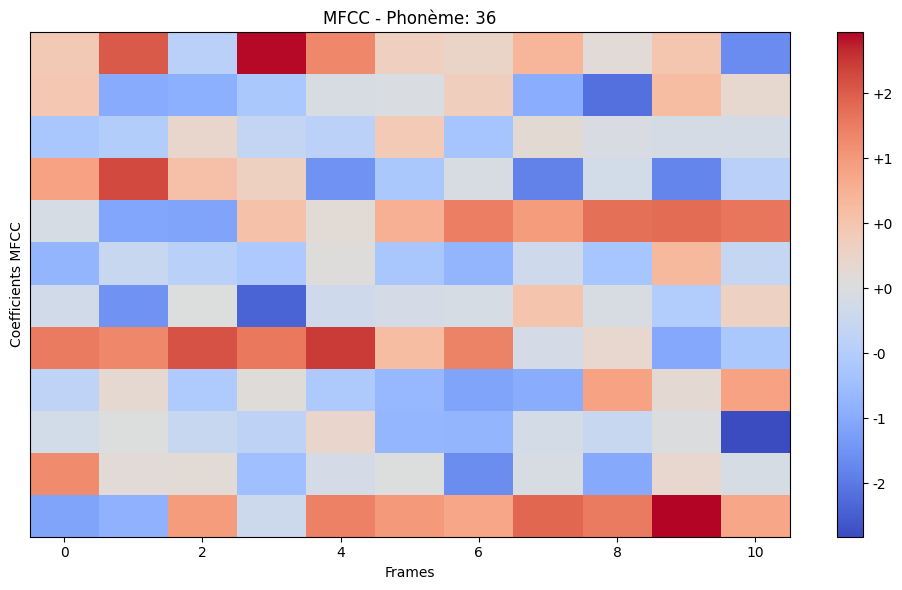

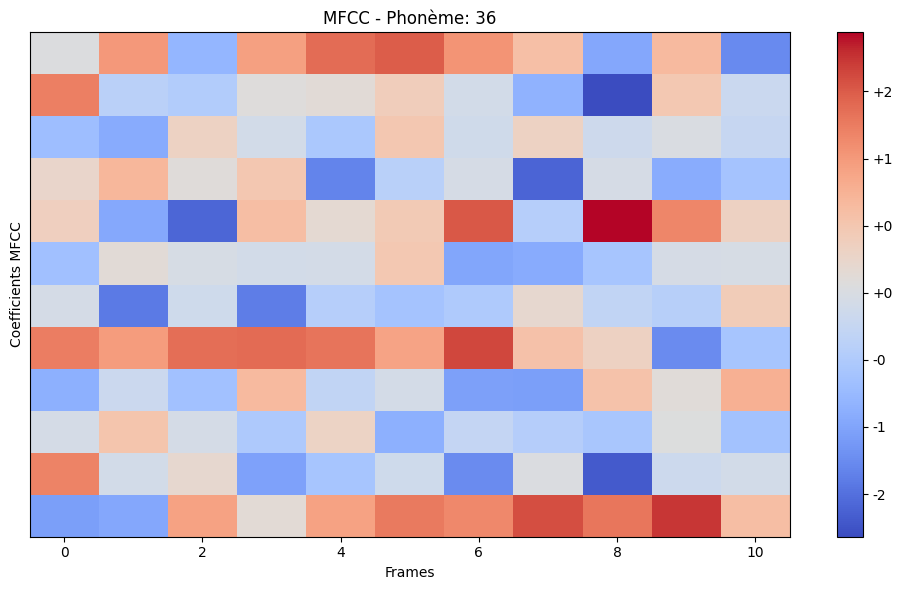

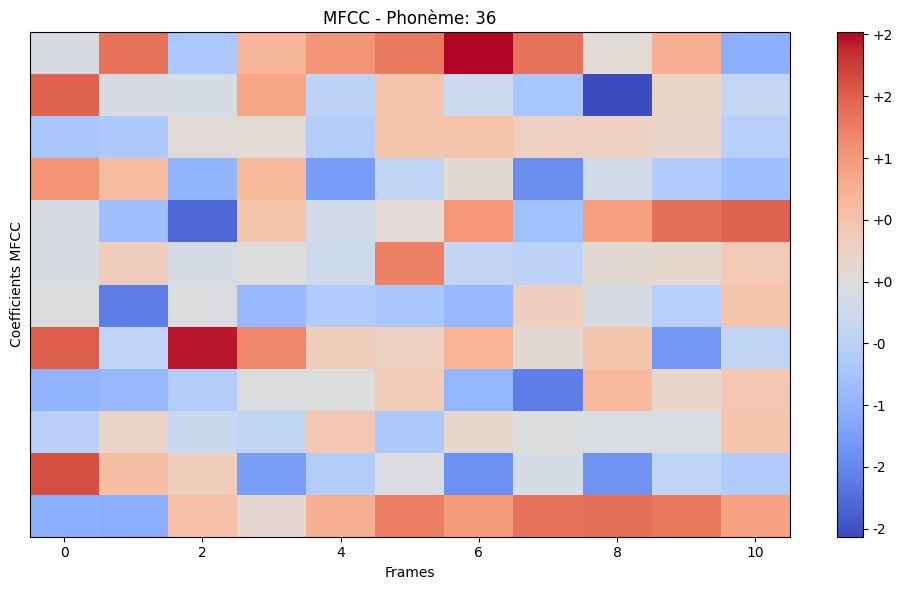

In [22]:
from matplotlib import pyplot as plt
import librosa

# ------------------------- Affichage d'un exemple d'un ensemble de donnée de l'ensemble d'apprentissage --------------------------------------------

  Exemple, Label = train_x[k], train_y[k]

  # Selection de l'exemple à traiter
  k = 15

  # Reshape (39 features x 11 frames)
  donnes = np.reshape(Exemple, (39, 11))

  # Extraction des 12 premiers coefficients MFCC
  mfccs = donnes[:12, :]

  # Affichage de la matrice MFCC
  plt.figure(figsize=(10, 6))
  img = librosa.display.specshow(mfccs, x_axis='frames')
  plt.colorbar(img, format='%+2.0f')
  plt.title(f'MFCC - Phonème: {Label}')
  plt.ylabel('Coefficients MFCC')
  plt.tight_layout()
  plt.show()




***Quel est le label associé ? (code + signification)***

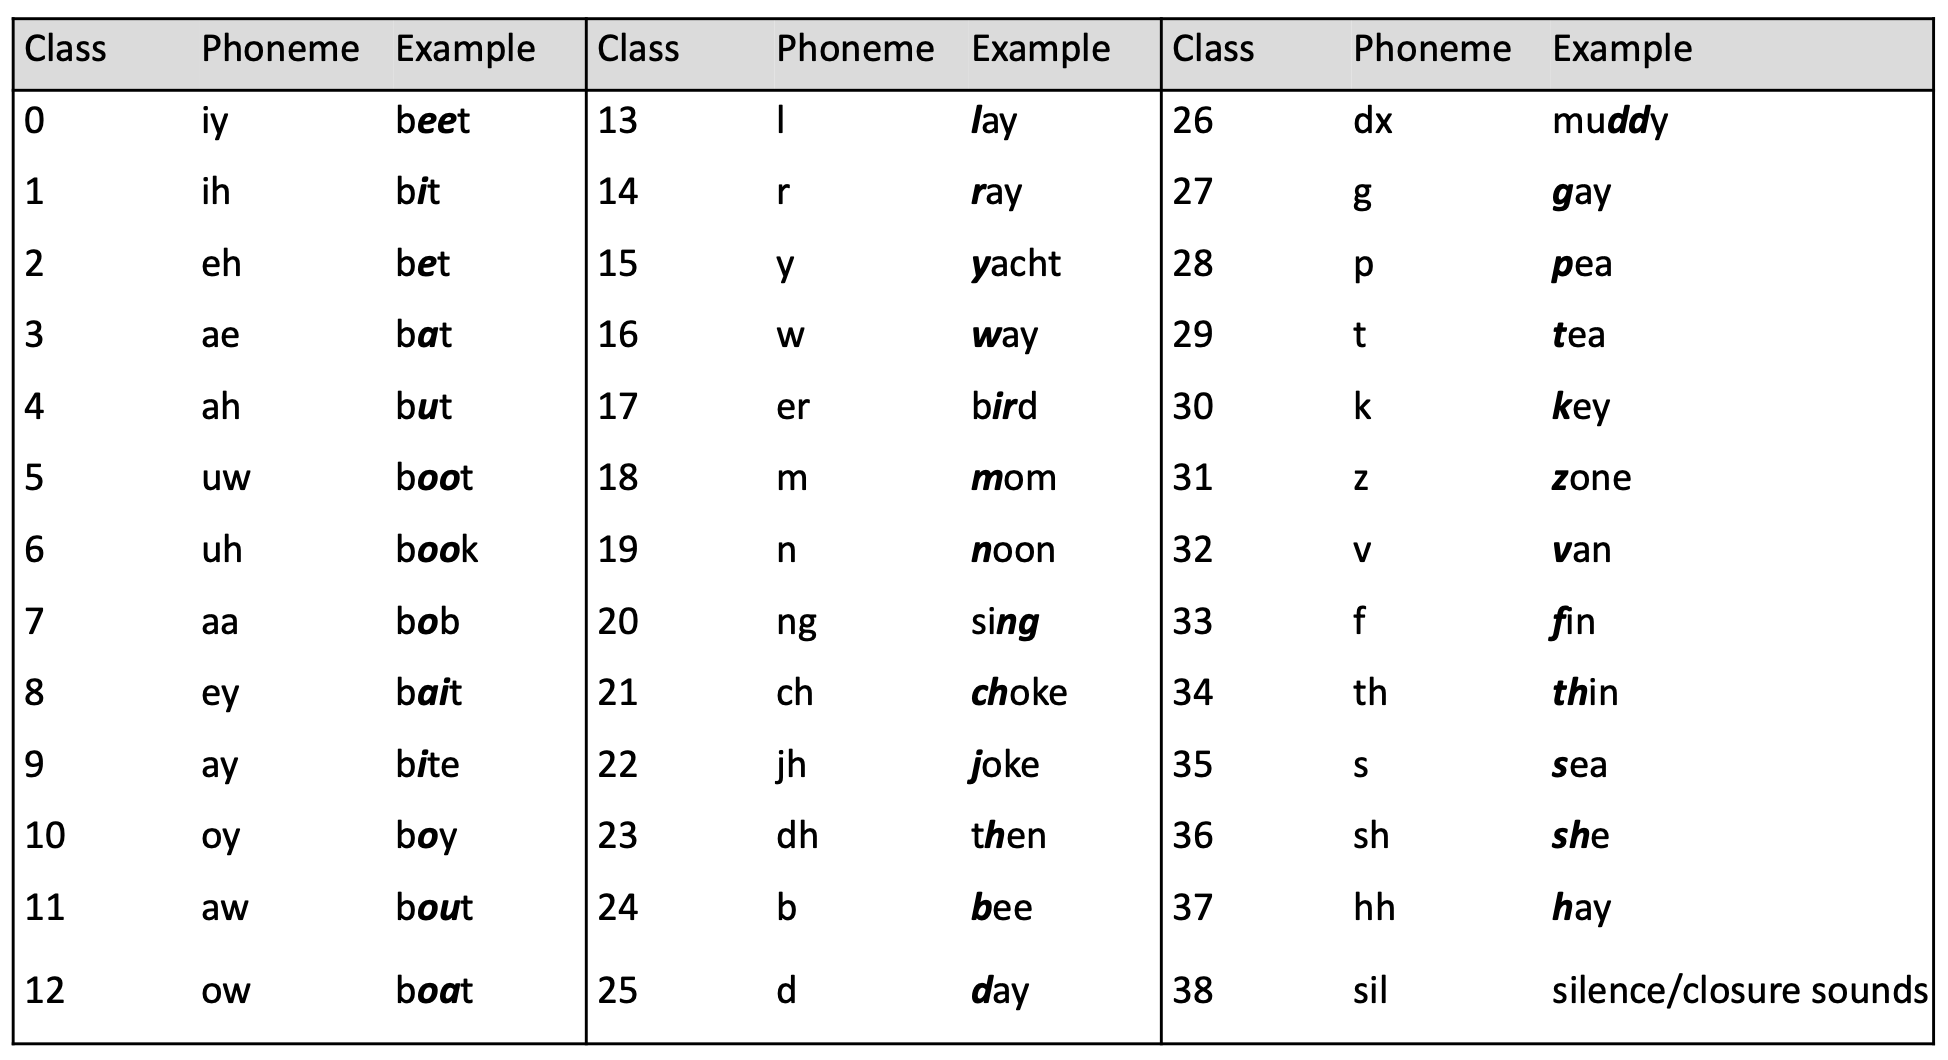

In [7]:
print(f" Le label associé à l'exemple est : {Label}\n","Il correspond au phonème [ih]")


 Le label associé à l'exemple est : 1
 Il correspond au phonème [ih]


Créez un chargeur de données à partir du jeu de données, n'hésitez pas à modifier la variable `BATCH_SIZE` ici.

In [8]:
BATCH_SIZE = 2056

from torch.utils.data import DataLoader

train_set = TIMITDataset(train_x, train_y)
val_set = TIMITDataset(val_x, val_y)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True) #only shuffle the training data
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

Nettoyer les variables inutiles pour économiser de la mémoire.
<br>

**notes: si vous avez besoin d'utiliser ces variables plus tard, vous pouvez supprimer ce bloc ou nettoyer les variables inutiles plus tard<br>la taille des données est assez importante, il faut donc faire attention à l'utilisation de la mémoire dans la colab...**

In [9]:
import gc

del train, train_label, train_x, train_y, val_x, val_y
gc.collect()

70

## Création d'un modèle

In [10]:
import torch
import torch.nn as nn

class Classifier(nn.Module):
    def __init__(self, num_classes = 39):
        super(Classifier, self).__init__()
        self.layers = nn.Sequential(
           nn.Linear(11 * 39, 2048),
            nn.ReLU(),
            nn.BatchNorm1d(2048),
            nn.Dropout(0.5),

            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.5),

            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),

            nn.Linear(256, num_classes)
          )



    def forward(self, x):
        x = self.layers(x)

        return x

## Apprentissage

In [11]:
#check device
def get_device():
  return 'cuda' if torch.cuda.is_available() else 'cpu'

Fixer le générateur aléatoire pour la reproductibilité.

In [12]:
# fix random seed
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

Paramètres d'apprentissage

In [13]:
# fix random seed for reproducibility
same_seeds(0)

# get device
device = get_device()
print(f'DEVICE: {device}')

# training parameters
num_epoch = 10               # number of training epoch
learning_rate = 0.001     # learning rate

# the path where checkpoint saved
model_path = './model.ckpt'

# create model, define a loss function, and optimizer
model = Classifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

DEVICE: cuda


In [14]:
# start training
best_acc = 0.0
train_loss_tab, val_loss_tab = [], []
train_set_len = len(train_loader)
val_set_len = len(val_loader)

for epoch in range(num_epoch):
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0

    # training
    model.train() # set the model to training mode
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        batch_loss = criterion(outputs, labels)
        _, train_pred = torch.max(outputs, 1) # get the index of the class with the highest probability
        batch_loss.backward()
        optimizer.step()

        train_acc += (train_pred.cpu() == labels.cpu()).sum().item()
        train_loss += batch_loss.item()

    train_loss_tab.append(train_loss / len(train_loader))
    # validation
    if len(val_set) > 0:
        model.eval() # set the model to evaluation mode
        with torch.no_grad():
            for i, data in enumerate(val_loader):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                batch_loss = criterion(outputs, labels)
                _, val_pred = torch.max(outputs, 1)

                val_acc += (val_pred.cpu() == labels.cpu()).sum().item() # get the index of the class with the highest probability
                val_loss += batch_loss.item()
            val_loss_tab.append(val_loss / len(val_loader))

            print('[{:03d}/{:03d}] Train Acc: {:3.6f} Loss: {:3.6f} | Val Acc: {:3.6f} loss: {:3.6f}'.format(
                epoch + 1, num_epoch, train_acc/len(train_set), train_loss/len(train_loader), val_acc/len(val_set), val_loss/len(val_loader)
            ))

            # if the model improves, save a checkpoint at this epoch
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), model_path)
                print('saving model with acc {:.3f}'.format(best_acc/len(val_set)))
    else:
        print('[{:03d}/{:03d}] Train Acc: {:3.6f} Loss: {:3.6f}'.format(
            epoch + 1, num_epoch, train_acc/len(train_set), train_loss/len(train_loader)
        ))

# if not validating, save the last epoch
if len(val_set) == 0:
    torch.save(model.state_dict(), model_path)
    print('saving model at last epoch')

[001/010] Train Acc: 0.553631 Loss: 1.492441 | Val Acc: 0.670757 loss: 1.049690
saving model with acc 0.671
[002/010] Train Acc: 0.622730 Loss: 1.224101 | Val Acc: 0.693349 loss: 0.963463
saving model with acc 0.693
[003/010] Train Acc: 0.644496 Loss: 1.146325 | Val Acc: 0.708353 loss: 0.912014
saving model with acc 0.708
[004/010] Train Acc: 0.658075 Loss: 1.096577 | Val Acc: 0.715827 loss: 0.884867
saving model with acc 0.716
[005/010] Train Acc: 0.668554 Loss: 1.059955 | Val Acc: 0.720034 loss: 0.864470
saving model with acc 0.720
[006/010] Train Acc: 0.675978 Loss: 1.033596 | Val Acc: 0.725904 loss: 0.845091
saving model with acc 0.726
[007/010] Train Acc: 0.681289 Loss: 1.011743 | Val Acc: 0.729113 loss: 0.833121
saving model with acc 0.729
[008/010] Train Acc: 0.687170 Loss: 0.992738 | Val Acc: 0.734560 loss: 0.817924
saving model with acc 0.735
[009/010] Train Acc: 0.691363 Loss: 0.977774 | Val Acc: 0.735070 loss: 0.809827
saving model with acc 0.735
[010/010] Train Acc: 0.69509

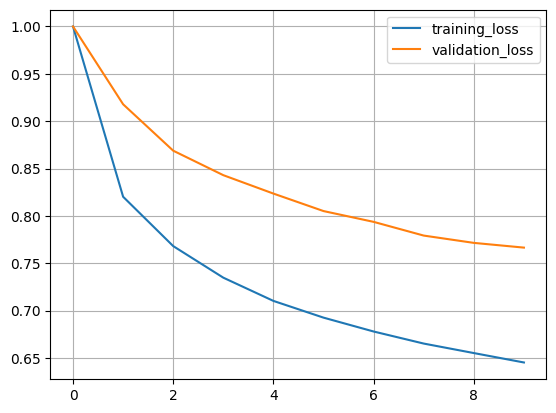

In [15]:
# Les plots n'ont aucun sens jusqu'à présent

plt.plot(train_loss_tab/np.max(train_loss_tab))
plt.plot(val_loss_tab/np.max(val_loss_tab))
plt.legend(["training_loss", "validation_loss"])
plt.grid()
plt.show()



## Travail à faire

1. Affichez les courbes d'apprentissage et la fonction de perte de l'apprentissage et de la validation
2. Affichez une matrice de confusion des phonèmes sur l'ensemble de validation
3. Modifiez le modèles. Vous pouvez jouer sur :
  * Architecture du modèle
  * Apprentissage (taille du batch, fonction d'optimisation, taux d'apprentissage, nombre d'epoch)
  * Optimisation (batch norm, dropout, fonctions de regularisation)


Attention : si vous enclenchez le GPU (Exécution -> Modifiez le type d'execution), ca devrait fonctionner 20x plus vite, mais Google limite l'utilisation gratuite un ou deux heures par jour. Je ne vous demande pas de faire des tonnes de modifications, essayez-en deux ou trois et commentez les résultats. Vous pouvez dupliquer le code pour afficher les différentes versions que vous avez exécuté.

Remarque : si vous voulez sauvegarder vos modèles, téléchargez le fichier de votre modèle avant de quitter votre session, ou bien effectuez une liaison avec votre Google drive ([exemple ici](https://www.youtube.com/watch?v=iAoKSiToZmA)) et changez le chemin dans le code.

# Remarques :

Première tentative :
- Modèle : self.layers = nn.Sequential(  
          nn.Linear(429, 1024),
          nn.ReLU(),
          nn.Linear(1024, 512),
          nn.ReLU(),
          nn.Linear(512, 128),
          nn.ReLU(),
          nn.Linear(128, 39)
          )
- Résultat : [010/010] Train Acc: 0.145910 Loss: 3.292095 | Val Acc: 0.142877 loss: 3.297622

Deuxième tentative :
- Ajout de couches dropout.
- Résulta pas fou

Troisième tentative :
- Ajout de couches BatchNorm1d
- Résultat plutôt pas mal (Précis à 59 %) mais les losses sont énormes.
- Modèle : self.layers = nn.Sequential(  
           nn.Linear(11 * 39, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.5),
            
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            
            nn.Linear(256, num_classes)
          )

Quatrième tentative :
- Diminution du Learning Rate.
- Le modèle est précis à 70%.

In [16]:
# A vous...

Détaillez ici votre démarche et les améliorations que vous avez apporté au modèle initial. Commentez les courbes et la matrice de confusion à chaque fois.

...